Shape of x:  (768, 8)
Shape of y:  (768,)
Shape of x_train:  (640, 8)
Shape of x_test:  (128, 8)
Shape of x_train:  (640, 9)
Shape of x_test:  (128, 9)
GD Iteration 1, Objective: 0.693134
GD Iteration 2, Objective: 0.693120
GD Iteration 3, Objective: 0.693106
GD Iteration 4, Objective: 0.693093
GD Iteration 5, Objective: 0.693079
GD Iteration 6, Objective: 0.693066
GD Iteration 7, Objective: 0.693052
GD Iteration 8, Objective: 0.693039
GD Iteration 9, Objective: 0.693025
GD Iteration 10, Objective: 0.693011
GD Iteration 11, Objective: 0.692998
GD Iteration 12, Objective: 0.692984
GD Iteration 13, Objective: 0.692971
GD Iteration 14, Objective: 0.692957
GD Iteration 15, Objective: 0.692943
GD Iteration 16, Objective: 0.692930
GD Iteration 17, Objective: 0.692916
GD Iteration 18, Objective: 0.692903
GD Iteration 19, Objective: 0.692889
GD Iteration 20, Objective: 0.692876
GD Iteration 21, Objective: 0.692862
GD Iteration 22, Objective: 0.692848
GD Iteration 23, Objective: 0.692835
GD Ite

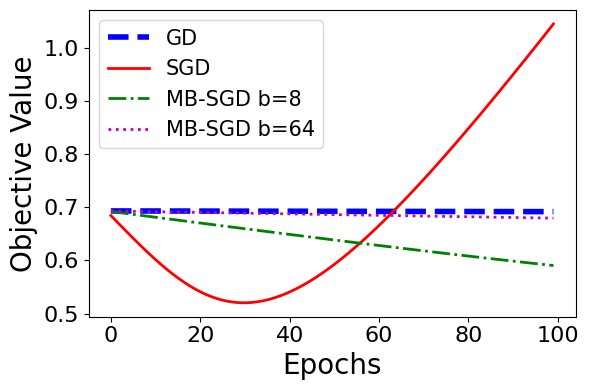

Training Classification Error:  0.2453125
Test Classification Error:  0.3046875


In [ ]:
# XinTongYu

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.datasets import load_svmlight_file

# 1. Load and preprocess data
x_sparse, y = load_svmlight_file('diabetes')
x = np.array(x_sparse.todense())

n = x.shape[0]
n_train = 640
n_test = n - n_train
rand_indices = np.random.permutation(n)
train_indices = rand_indices[:n_train]
test_indices = rand_indices[n_train:]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

# Standardize features
d = x_train.shape[1]
mu = np.mean(x_train, axis=0).reshape(1, d)
sig = np.std(x_train, axis=0).reshape(1, d)
x_train = (x_train - mu) / (sig + 1E-6)
x_test = (x_test - mu) / (sig + 1E-6)

# Add bias term
x_train = np.concatenate((x_train, np.ones((n_train, 1))), axis=1)
x_test = np.concatenate((x_test, np.ones((n_test, 1))), axis=1)

# 2. Objective function
def objective(w, x, y, lam):
    yx = y * x
    yxw = np.dot(yx, w)
    loss = np.mean(np.log(1 + np.exp(-yxw)))
    reg = lam / 2 * np.sum(w * w)
    return loss + reg

# 3. Gradient
def gradient(w, x, y, lam):
    yx = y * x
    yxw = np.dot(yx, w)
    grad = -np.mean(yx / (1 + np.exp(yxw)), axis=0).reshape(w.shape)
    return grad + lam * w

# 3.1 Gradient Descent
def grad_descent(x, y, lam, stepsize, max_iter=100, w=None):
    n, d = x.shape
    if w is None:
        w = np.zeros((d, 1))
    objvals = np.zeros(max_iter)
    for t in range(max_iter):
        objvals[t] = objective(w, x, y, lam)
        g = gradient(w, x, y, lam)
        w -= stepsize * g
    return w, objvals

# 3.2 SGD
def stochastic_objective_gradient(w, xi, yi, lam):
    xi = xi.reshape(1, -1)  
    yx = yi * xi            # 1xd
    yxw = float(np.dot(yx, w))  # scalar

    # Objective
    loss = np.log(1 + np.exp(-yxw))
    reg = lam / 2 * np.sum(w * w)
    obj = loss + reg

    # Gradient
    grad = -yx.T / (1 + np.exp(yxw)) + lam * w  # d x 1

    return obj, grad

def sgd(x, y, lam, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    if w is None:
        w = np.zeros((d, 1))
    objvals = np.zeros(max_epoch)
    for t in range(max_epoch):
        indices = np.random.permutation(n)
        x_rand = x[indices, :]
        y_rand = y[indices, :]
        objval = 0
        for i in range(n):
            xi = x_rand[i, :]
            yi = float(y_rand[i, :])
            obj, g = stochastic_objective_gradient(w, xi, yi, lam)
            objval += obj
            w -= stepsize * g
        stepsize *= 0.9
        objvals[t] = objval / n
    return w, objvals

# 3.3 Mini-Batch SGD
def mb_stochastic_objective_gradient(w, xi, yi, lam, b):
    yx = yi * xi
    yxw = np.dot(yx, w)
    loss = np.mean(np.log(1 + np.exp(-yxw)))
    reg = lam / 2 * np.sum(w * w)
    obj = loss + reg
    grad = -np.mean(yx / (1 + np.exp(yxw)), axis=0).reshape(w.shape)
    g = grad + lam * w
    return obj, g

def mb_sgd(x, y, lam, b, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    if w is None:
        w = np.zeros((d, 1))
    objvals = np.zeros(max_epoch)
    for t in range(max_epoch):
        indices = np.random.permutation(n)
        x_rand = x[indices, :]
        y_rand = y[indices, :]
        objval = 0
        for i in range(0, n, b):
            xi = x_rand[i:i+b, :]
            yi = y_rand[i:i+b, :]
            bi = xi.shape[0]
            obj, g = mb_stochastic_objective_gradient(w, xi, yi, lam, bi)
            w -= stepsize * g
            objval += obj * bi
        stepsize *= 0.9
        objvals[t] = objval / n
    return w, objvals

# 4. Run optimization
lam = 1E-6
stepsize_gd = 1.0
stepsize_sgd = 0.1
stepsize_mb = 0.1

w_gd, objvals_gd = grad_descent(x_train, y_train, lam, stepsize_gd)
w_sgd, objvals_sgd = sgd(x_train, y_train, lam, stepsize_sgd)
w_mb8, objvals_mbsgd8 = mb_sgd(x_train, y_train, lam, b=8, stepsize=stepsize_mb)
w_mb64, objvals_mbsgd64 = mb_sgd(x_train, y_train, lam, b=64, stepsize=stepsize_mb)

# 5. Plot comparison
plt.figure(figsize=(8, 6))
plt.plot(objvals_gd, label='GD')
plt.plot(objvals_sgd, label='SGD')
plt.plot(objvals_mbsgd8, label='MB-SGD (batch size = 8)')
plt.plot(objvals_mbsgd64, label='MB-SGD (batch size = 64)')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Objective Function Value', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('compare_all_methods.png', dpi=300)
plt.show()

# 6. Prediction
def predict(w, X):
    return np.sign(np.dot(X, w))

f_train = predict(w_mb64, x_train)
f_test = predict(w_mb64, x_test)
train_error = np.mean(np.abs(f_train - y_train) / 2)
test_error = np.mean(np.abs(f_test - y_test) / 2)

print(f"Training classification error: {train_error:.4f}")
print(f"Test classification error: {test_error:.4f}")